# Fill the gaps
In this notebooks we will

1. Clean the columns meaning and content 
2. Fill the gaps
  
The first task is trivial but needed to simplify those columns that where populated automatically in the [normalization step](normalize_CL.py), the second will take the majority of the notebook.

I want to fill the gaps in the floor, parking, and furnished features. However, the furnished feature has only sure yes, so, at the moment, I avoid working on it.

For the floor and parking features, we balance our training set, then use a `Decision Tree` to find the determining features, and finally train different ML models to pick up the two models that learned the best (using `GridSearchCV`). 
We then use them to predict the missing floors or parking informations. 
Since we predict from two ML, we can also see how much they agree or disagree. Of course they do not agree on all predictions, but for most they do.

In [19]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
dataframe = pd.read_hdf('data/after_ML1.h5','housesofparis')

In [21]:
remapcols = {
    'type':('apartment','house','townhouse','flat','duplex','condo'),
    'laundry':('laundry on site','no laundry on site','laundry in bldg'),
    'parking':('no parking','attached garage','street parking','carport','off-street parking')}
remapcols_v = {
    'type':range(len(remapcols['type'])),
    'laundry':(1,0,1), # yes/no some kind of laundry
    'parking':(0,1,1,1,1)} #y/no some kind of parking

In [22]:
df2 = dataframe.copy()
for typ in remapcols:
    df2[typ]=None
    for oldcol,value in zip(remapcols[typ],remapcols_v[typ]):
        df2.ix[dataframe[oldcol],typ]=value+1
        df2.drop(oldcol,1,inplace=True)

## Preparing the labels and features datasets
We want to predict the aparment floor and wetheter it contains a laundry.

We will train a machine learning algorithm from the rows that already have those fields,
and predict the missing values. The results will be stored in new columns ``predicted_floor`` and ``predicted_laundry``.

Several steps are needed to ensure we get meaninfull results:

1. We need to choose representative features (aka columns). We choose the columns that have the highest variance (see Scikit-learn User guide), 
    with the highest count, thus that statistic to be as solid as possible.
2. We normalize the distribution of labels to avoid that few classes dominate over the others. As ML algorithms are based on ``statistical`` learning,
    when one (or few) classes dominate over the others, the ML will predict only the most probable classes.
3. We train (and hyper-optimize) a ``Decision Tree`` to choose the most representative classes. E.g.: the features ``price``, ``sqm``, and ``price_sqm`` may all have a high variance and count, but only two of them is independent, because we compute ``price_sqm=price/sqm``.
4. We choose and train the best ML model.
5. Predict the missing fields with the chosen model.


Once the last point is done,
we will have a new dataset with the columns of the predicted floors and laundry state. 
In another NB I will use it to look for new patterns, as done in (ML 1)[ML 1]

In [46]:
ll = []
for jj,feat_name in enumerate(df2.columns):
    try:
        col = df2[feat_name].astype(float).copy()
    except ValueError:
        continue
    col = col[col>=0] # because I marked <0 those that I do not know
    col -= col.min()
    col /= col.max()
    ll.append([feat_name,col.count(),col.mean(),col.var(),jj])
    
var = [j[-2] for j in ll] 
ll = [ll[j] for j in np.argsort(var)]
print " #| col name              |count  | mean | var*|"
for z in ll:
    print "{4:2d} {0:25s}    {1:3.0f}  {2:3.3f} {3:3.3f}|".format(*z)

 #| col name              |count  | mean | var*|
13 w/d hookups                  601  0.002 0.002|
 3 sqm                          601  0.034 0.004|
 4 price                        601  0.135 0.007|
24 type                         593  0.011 0.009|
22 price_sqm                    601  0.418 0.025|
20 price_bin                    601  0.271 0.027|
16 wheelchair accessible        601  0.050 0.048|
21 sqm_bin                      601  0.328 0.060|
 1 idx                          601  0.563 0.062|
 5 floor                        181  0.312 0.067|
 8 district                     475  0.487 0.089|
14 dogs are OK - wooof          601  0.113 0.101|
12 no smoking                   601  0.138 0.119|
15 w/d in unit                  601  0.143 0.123|
23 laundry                       59  0.831 0.143|
25 parking                       87  0.655 0.229|
11 furnished                    601  0.401 0.241|
19 district_binary              601  0.406 0.242|
26 predicted_floor              601  0.576 0.245|


To choose which features to use, we first make a long list of _reasonable_ features.
We feed the corresponding data set to the ``Decision Tree`` and then pick only those that are important to the ``Decision Tree``.

In [77]:
to_predict = 'parking'

#before feature selection
all_features=[11,12,14,8,5,22,24,4,3,16]
#after feature selection (2 rounds)
all_features=[11,8,5,22,3,25]
#
all_features_name=df2.columns[all_features].tolist()
def get_features_labels(label,all_features,data):
    features=[j for j in all_features if j!=label]
    # filter removing records with empty fields
    data_nna = data[all_features].dropna()
    return data_nna[label].get_values().astype(float),data_nna[features].get_values().astype(float),features

labels,features, features_name=get_features_labels(to_predict,all_features_name,df2[(df2.floor>=0) & (df2.district>0)])

## Labels distributions

If the distribution of labels is not even, the ML may 
learn to cheat

/home/astyonax/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/astyonax/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


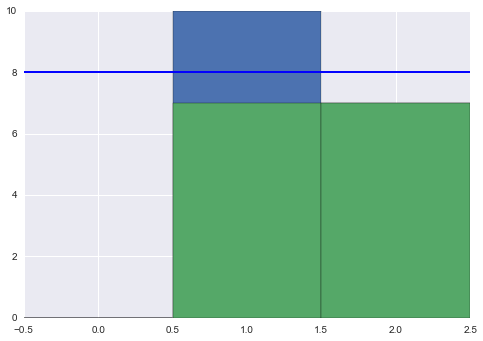

In [78]:
counts,idx,_=sns.plt.hist(labels,bins=np.arange(0,max(labels)+2,1)-.5)
trhs_func = lambda x: np.median(x)+1
trhs1 = trhs_func(counts)
sns.plt.axhline(trhs1)

prob_normalize = {}
for lbl in labels:
    if counts[lbl]<=trhs1:
        prob_normalize[lbl]=lambda : True
    else:
        prob_normalize[lbl]= lambda : np.random.rand()> (counts[lbl]-1.*trhs1)/counts[lbl]
        
def lbl_prob_normalize(lbl):
    return prob_normalize[lbl]()

idxxs = np.where(map(lbl_prob_normalize,labels))


newlabels = labels[idxxs]
newfeatures = features[idxxs]
    
counts,idx,_=sns.plt.hist(newlabels,bins=np.arange(0,max(labels)+2,1)-.5)
trhs1 = trhs_func(counts)
sns.plt.axhline(trhs1);


## Identify  features with a Decision Tree
The ML model ``Decision Tree`` tells which and how much each field is important 
for the classification.

The information is stored in the field ``feature_importances_``.

ML algorithms are trained (fitted in ``scikit-learn`` terms), and each ML algorithm may depend on some parameter (often to smoothen/regularize the input noise). 
To aboid common overfitting/underfitting problems, we use the ``GridSearchCV`` algorithm, explained in this (wonderful) video: [...].
Thus the steps are:

1. Normalize the data-set
2. Make a ML
3.  *Make train, test, validate test
4.  *Fit
5.  *Test
6.  *Optimize Hyper param
7.  *Validate

Where all steps with (*) are done by ``GridSearchCV``

In [79]:
#Normalize
from sklearn.preprocessing import StandardScaler,Normalizer
scaler = StandardScaler()
normer = Normalizer()
features = normer.fit_transform(features)

In [80]:
from sklearn.grid_search import GridSearchCV
name = 'DecisionTree'
params_tree = {'min_samples_leaf':range(1,20),
               'max_depth':[None,3,5,7,10,15,20],
               'max_leaf_nodes':[None,5,10,50,100]}
GSCV=GridSearchCV(dcsTR,params_tree,cv=3,n_jobs=3).fit(features,labels)
opt_score=GSCV.best_score_
print "{0:15s}:  {1:.3f}".format(name,opt_score*100)
dcstree = tree.DecisionTreeClassifier(**GSCV.best_params_).fit(features,labels)
idxs = np.argsort(dcstree.feature_importances_)[::-1]
print '-'*40
print 'Features, sorted by relative importance:'
for i,idx in enumerate(idxs):
    print "{0:d} {1:15s} {2:.3f}".format(i,
                                         features_name[idx],
                                         dcstree.feature_importances_[idx])

DecisionTree   :  94.118
----------------------------------------
Features, sorted by relative importance:
0 district        0.787
1 sqm             0.162
2 price_sqm       0.051
3 floor           0.000
4 furnished       0.000


In [81]:
var = [j[-2] for j in ll] 
ll = [ll[j] for j in np.argsort(var)]
print " # | col name              |count  | mean | var*|"
for z in ll:
    if z[0] in all_features_name:
        print "{4:2d} * {0:23s}    {1:3.0f}  {2:3.3f} {3:3.3f}|".format(*z)
        print "-"*49
    else:
        print "{4:2d} {0:25s}    {1:3.0f}  {2:3.3f} {3:3.3f}|".format(*z)

 # | col name              |count  | mean | var*|
13 w/d hookups                  601  0.002 0.002|
 3 * sqm                        601  0.034 0.004|
-------------------------------------------------
 4 price                        601  0.135 0.007|
24 type                         593  0.011 0.009|
22 * price_sqm                  601  0.418 0.025|
-------------------------------------------------
20 price_bin                    601  0.271 0.027|
16 wheelchair accessible        601  0.050 0.048|
21 sqm_bin                      601  0.328 0.060|
 1 idx                          601  0.563 0.062|
 5 * floor                      181  0.312 0.067|
-------------------------------------------------
 8 * district                   475  0.487 0.089|
-------------------------------------------------
14 dogs are OK - wooof          601  0.113 0.101|
12 no smoking                   601  0.138 0.119|
15 w/d in unit                  601  0.143 0.123|
23 laundry                       59  0.831 0.143|


## Choose a ML model

Different ML models are available in ``scikit learn``. Each of them fit different problems.
To find which ML model fits better our dataset we compare their score obtained after optimizing their hyper paramters with ``GridSearchCV``.
### Non-optimized parameters

In [82]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.svm import SVC,LinearSVC
from sklearn import tree

# Hyper parameters optimization with gridsearch
import  sklearn.cross_validation as sklCV

gsNB = GaussianNB()
mnNB = MultinomialNB()
blNB = BernoulliNB()
svcrbf = SVC(kernel='rbf')
svclin = LinearSVC()
svcsig = SVC(kernel='sigmoid')
dcsTR = tree.DecisionTreeClassifier()

NaiveBayeses = [gsNB,mnNB,blNB,svcrbf,svcsig,svclin,dcsTR]

gen = lambda x:(j for j in x)
m_v = lambda x: (x.mean(),x.std())
names = gen(('Gaussian','multinomial','bernoulli','svcrbf','svclinear','svcsigmoid','DecisionTree'))
for nb in NaiveBayeses:
    score,var = m_v(sklCV.cross_val_score(estimator=nb,X=features,y=labels,cv=6))
    print u"{0:15s}:  {1:.3f} ± {2:.3f}".format(names.next(),score*100,var*100)

Gaussian       :  84.722 ± 24.728
multinomial    :  63.889 ± 17.786
bernoulli      :  52.778 ± 11.453
svcrbf         :  58.333 ± 8.333
svclinear      :  58.333 ± 8.333
svcsigmoid     :  80.556 ± 27.916
DecisionTree   :  76.389 ± 26.535


### Optimized paramters

In [83]:
from sklearn.grid_search import GridSearchCV
NaiveBayeses = [gsNB,mnNB,blNB,svcrbf,svclin,svcsig,dcsTR]
names = gen(('Gaussian','multinomial','bernoulli','svcrbf','svclinear','svcsigmoid','DecisionTree'))
params_bl_mn = {'alpha':np.logspace(-2,4,500)}
params_svc = {'C':np.logspace(-2,3,50),'gamma':np.logspace(-2,3,50)}
params_svc_lin = {'C':np.logspace(-2,3,50)}
params_tree = {'min_samples_leaf':range(1,20),'max_depth':[None,3,5,7,10,15,20],'max_leaf_nodes':[None,5,10,50,100]}
params = gen(({},params_bl_mn,params_bl_mn,params_svc,params_svc_lin,params_svc,params_tree))

GSCVs = []
for nb in NaiveBayeses:
    name = names.next()
    param = params.next()
    GSCV=GridSearchCV(nb,param,cv=3,n_jobs=3).fit(features,labels)
    opt_score=GSCV.best_score_
    GSCVs.append((name,GSCV))
    print "{0:15s}:  {1:.3f}%".format(name,opt_score*100)
GSCVs = dict(GSCVs)

Gaussian       :  82.353%
multinomial    :  64.706%
bernoulli      :  58.824%
svcrbf         :  94.118%
svclinear      :  88.235%
svcsigmoid     :  82.353%
DecisionTree   :  94.118%


In [84]:
DT = GSCVs['DecisionTree']
predicted_labels = DT.predict(features)

print "Prediction accuracy of known data: {0:.0f}%".format(
    100-np.sum(labels-predicted_labels).astype(bool)/labels.shape[0]*100)

Prediction accuracy of known data: 100%


So, the ``decision tree`` and the ``SVC-RBF``  machine are the ones that perform the best.

## Predicting the missing labels
Let's use the trained ML to predict the missing labels

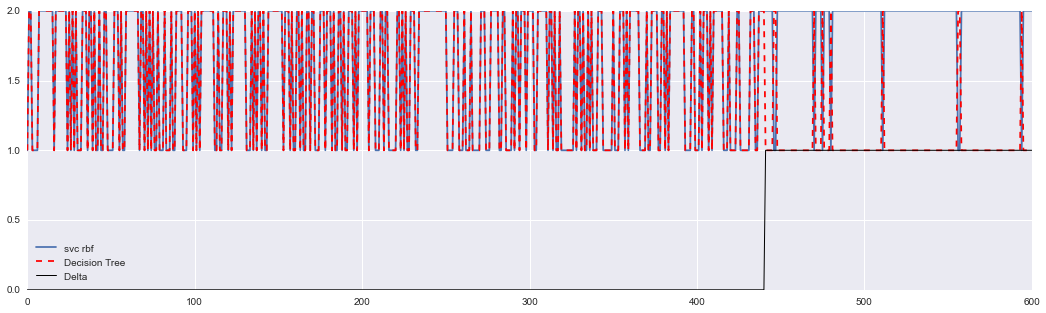

In [85]:
input_df = df2[features_name]
unknown = normer.transform(input_df.get_values().astype(float))

predicted_labels_svcrbf = GSCVs['svcrbf'].predict(unknown)
predicted_labels_dt = GSCVs['DecisionTree'].predict(unknown)
Delta = np.abs(predicted_labels_dt-predicted_labels_svcrbf)
idxx = np.argsort(Delta)
sns.plt.plot(predicted_labels_svcrbf[idxx], label = 'svc rbf')
sns.plt.plot(predicted_labels_dt[idxx],'--r',label = 'Decision Tree')
sns.plt.plot(Delta[idxx],'k',lw=1,label = 'Delta ')
sns.plt.legend(loc='best')
fig = sns.plt.gcf()
fig.set_size_inches(18,5)
# print predicted_labels
# df2['predicted_floor']=predicted_labels

In [86]:
df2['predicted_{0:s}'.format(to_predict)]=predicted_labels_dt

# Final remarks

Save the new dataset!!

In [91]:
df2.to_hdf('data/after_ML1.h5','houseofparis_2')

In [94]:
from IPython.display import HTML
import urllib2

style=open('style.css','r').read()
HTML("""
<style>{0}</style>
""".format(style))